Module 5, Lab 3: Between Subjects Experiments
=============================================

In this lab, we will explore the between-subjects experiment (sometimes
referred to as an "A/B" test). I apply concepts from across the entire
course, including review of statistical modeling, power analysis, effect
size, measurement, and so on ... so that you can see the entire process
at once.

In this example, a design firm has produced several different logos for
a company as part of a rebranding process, and the company executives
have selected three that they like. These were then tested on a sample
of 100 customers. Each participant completed a survey about a randomly
selected logo. You are the data analyst and were called upon to make
sense of the data.

As part of the survey, participants rated their impression of the logo
on several dimensions: "friendly", "inviting", "interesting",
"positive", "pleasant" on a 1-10 scale (1 = *does not describe logo*; 10
= *describes logo perfectly*). As these are all positive adjectives and
you suspect people will not be very discerning in their answers, you
wish to combine them into a single "positive sentiment" scale. You then
wish to compare the logos on this sentiment scale.

We will use a number of packages in this lab:

In [1]:
#### LOAD PACKAGES ####
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.stats.weightstats as ws
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Load the Data
=============

We first load the data and inspect it.

In [2]:
#### LOAD DATA ####
dat = pd.read_csv("datasets/logos.csv")

We quickly glance at the names of the variables:

In [3]:
dat.columns

Index(['id', 'friendly', 'inviting', 'interesting', 'positive', 'pleasant',
       'sex', 'logo'],
      dtype='object')

1.  We have an ID variable representing the individual participants
2.  We have variables representing the different adjectives on which
    people rated the logo
3.  We have participant sex
4.  We have the logo that was rated

It is clear this is not the whole dataset, as there would likely have
been more variables.

Let's briefly check the structure of the dataset:

In [4]:
dat.head()

,id,friendly,inviting,interesting,positive,pleasant,sex,logo
0,3,9,8,9,10,9,f,Logo A
1,98,7,6,8,7,7,f,Logo C
2,73,5,3,6,6,6,m,Logo C
3,89,4,5,2,3,4,f,Logo C
4,13,8,7,9,8,6,f,Logo A


Happily for us, we have the adjectives all scored as numeric variables
and the `logo` variable scored as a categorical variable. We will need to do little
(or nothing) to wrangle the data.

We do a final quick inspection on the variables in the dataset.

In [5]:
dat.describe()

,id,friendly,inviting,interesting,positive,pleasant
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,8.050000,7.990000,7.930000,8.000000,7.890000
std,29.011492,1.520068,1.690705,1.810491,1.797866,1.740167
min,1.000000,4.000000,3.000000,2.000000,3.000000,3.000000
25%,25.750000,7.000000,7.000000,7.000000,7.000000,7.000000
50%,50.500000,8.000000,8.000000,8.000000,8.000000,8.000000
75%,75.250000,9.000000,9.000000,10.000000,10.000000,9.250000
max,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000


We see here that the ranges on the adjective variables are all in range
(1-10), which we should expect (but should still check). The `logo` was
randomly assigned to participants, so this is approximately evenly
distributed. Annoyingly, we have a missing value on the `logo` variable.
Of note,`sex` weights toward females, which we assume is representative
of the data source. Hopefully this is representative of likely customers
(if not, this would be a key limitation of this study).

Score the Scale
===============

We had the goal of creating a "positive sentiment" variable for these
data. We can quickly eyeball a correlation matrix to ensure these
measures correlate highly with each other. The adjectives represent
columns 2-6 of `dat`, so the correlations among the adjectives can be
shown with that subset. Remember that the double brackets after `dat`
contain contain the list of numeric variable columns. Note that I added the
`round(3)` method to enhance readability, rounding to two decimals:

In [6]:
dat[['friendly', 'inviting', 'interesting', 'positive', 'pleasant']].corr().round(3)

,friendly,inviting,interesting,positive,pleasant
friendly,1.000,0.857,0.867,0.824,0.854
inviting,0.857,1.000,0.663,0.698,0.758
interesting,0.867,0.663,1.000,0.770,0.725
positive,0.824,0.698,0.770,1.000,0.688
pleasant,0.854,0.758,0.725,0.688,1.000


We see these ratings are all moderately-strongly correlated. Later in
your training, you might learn to run a principal components analysis or
a factor analysis to ensure they appear to represent "one underlying
factor" (i.e., sentiment). For now, we can be satisfied with showing
acceptable correlations among the ratings and by showing acceptable
scale reliability.

Next, we proceed to score it as a sale. We use the Pandas `apply` method to apply the `mean` function from the numpy package to each row (`axis = 1`) to the numeric columns of the data frame to compute a`sentiment` variable:

In [7]:
dat['sentiment'] = dat[['friendly', 'inviting', 'interesting', 'positive', 'pleasant']].apply(np.mean, axis = 1)
dat.head()

,id,friendly,inviting,interesting,positive,pleasant,sex,logo,sentiment
0,3,9,8,9,10,9,f,Logo A,9.0
1,98,7,6,8,7,7,f,Logo C,7.0
2,73,5,3,6,6,6,m,Logo C,5.2
3,89,4,5,2,3,4,f,Logo C,3.6
4,13,8,7,9,8,6,f,Logo A,7.6


You can now see the sentiment variable in the data frame.

Let's check this measure.

Mean of Sentiment = 7.972000000000001
STD of Sentiment = 1.5357135149499732


Text(0.5, 0, 'Sentiment')

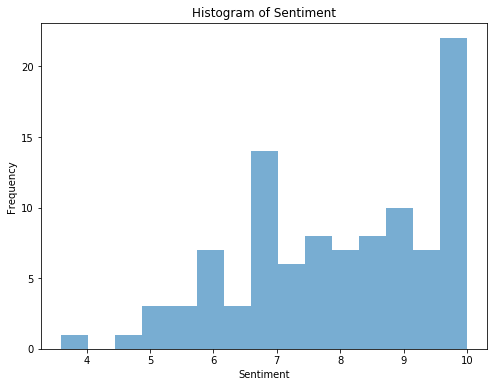

In [8]:
## Print some summary statistics
print('Mean of Sentiment = ' + str(np.mean(dat.sentiment)))
print('STD of Sentiment = ' + str(np.std(dat.sentiment)))

## Plot a histogram
ax = plt.figure(figsize=(8, 6)).gca() # define axis
dat.sentiment.plot.hist(ax = ax, alpha = 0.6, bins = 15)
plt.title('Histogram of Sentiment')
plt.xlabel('Sentiment')

We see that sentiment scores are skewed toward the positive end of the scale.

The next question is tougher. Are we **measuring sentiment and
not something else**, such as a tendency to respond positively on
surveys? In this case, we don't know. The adjectives seem representative
of the positive sentiment we would want to know about (i.e., content
validity) and appear good on their face (i.e., face validity). However,
we do not have evidence that this sent of adjectives teaks with other
indicators of sentiment in this study. Thus, we are accepting on faith
that these are a valid measure of sentiment. This is important to keep
in mind when interpreting results. It would be ideal if we had a set of
"tried and true" adjectives from prior studies that we could use that we
*know* correlate in ways that show their validity. For now, we just have
to trust the measure based on our impression.

Dealing With Missing Values
=====================================

Before we proceed with more analysis we must determine if the data have missing values. In a Pandas data frame missing values can be coded in a number of ways, including as a numpy `nan` or as `none`, a null value. The code in the cell below tests which columns have these codings for missing  values: 

In [9]:
for col in dat.columns:
    print(col + ' has missing values ' + 
          str((dat[col].isnull().values.any())) or str(dat[col].isna().values.any()))

id has missing values False
friendly has missing values False
inviting has missing values False
interesting has missing values False
positive has missing values False
pleasant has missing values False
sex has missing values False
logo has missing values True
sentiment has missing values False


The next step is to remove the missing values using the Pandas `dropna` method and test again to ensure we removed all the missing values: 

In [10]:
print(dat.shape)
dat.dropna(subset = ['logo'], inplace = True)
print(dat.shape)

## Check once more
print('\n')
for col in dat.columns:
    print(col + ' has missing values ' + 
          str((dat[col].isnull().values.any())) or str(dat[col].isna().values.any()))

(100, 9)
(99, 9)


id has missing values False
friendly has missing values False
inviting has missing values False
interesting has missing values False
positive has missing values False
pleasant has missing values False
sex has missing values False
logo has missing values False
sentiment has missing values False


One row was removed from the data frame and there are no more missing values!

Vizualize the Data + Run Descriptives
=====================================

The next step is to visualize the relationships in the data we want to
test. We also should examine the descriptive statistics to test our
question. In this case, we have randomly assigned participants to logos,
so everything about the participants (age, sex, consumption history,
etc.) will also be randomly distributed across the three logos. The
*only* systematic differences across the three groups was the logo.
Thus, any systematic differences in perceived friendliness can be
attributed to the logo. This is the beauty of an experimental design. We
can easily see the effect of the logo by comparing the groups.

In the between-subjects design, we compare means across groups. Thus, we
can visualize our data by looking at the distribution of scores across
logo groups. The plot is created using the `boxplot` method from Seaborn along with the `swarmplot` method so we can see the individual data points:

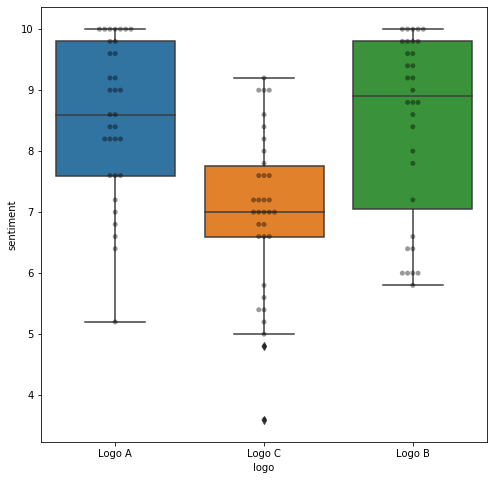

In [11]:
ax = plt.figure(figsize=(8,8)).gca() # define axis
sns.boxplot(x = 'logo', y = 'sentiment', data = dat, ax = ax)
sns.swarmplot(x = 'logo', y = 'sentiment', color = 'black', data = dat, ax = ax, alpha = 0.4)

![](Mod5_Lab3_-_Experiments_files/figure-markdown_strict/unnamed-chunk-11-1.png)
We can see in our sample that Logo A and B appear to result in the
highest positive sentiment, followed by Logo C. It's not clear whether
Logo A or B is better.

We can quickly compute some summary statistics. The Pandas `groupby` method groups the sentiment values by logo type and the mean is then computed:

In [12]:
logo_grouped = dat[['logo','sentiment']].groupby('logo')

print(' Mean by logo')
print(logo_grouped.mean().round(2))
print('\n Standard deviation by logo')
print(logo_grouped.std().round(2))

 Mean by logo
        sentiment
logo             
Logo A       8.58
Logo B       8.44
Logo C       7.00

 Standard deviation by logo
        sentiment
logo             
Logo A       1.27
Logo B       1.51
Logo C       1.33


Logo A and B look close together and ahead of Logo C. Of course, that is
just in our sample, so it is unclear whether we can infer there are real
differences in the population. For that, we need our inferential tests.

Inferential Test for Two Groups
===============================

In some experiments, you will have two groups to compare. For example,
in the Module 3 lab on causal claims, we explored such an experiment. In
others, you will have three or more groups. Although our overarching
example is three groups, let's review this and pretend for a while that
you were *only* comparing logos A and B to illustrate the two-group
example.

Whenever you compare (means of) two groups, you conduct an independent
samples *t*-test. You can also use regression (run a regression
predicting your outcome from your two-group predictor), but the *t*-test
is commonly done and is illustrated here.

Recall that Logo A did better *in our sample*, but is this a *real*
difference in the population or just an artifact of random chance (due
to reliance on random assignment to groups)?

Recall that the null hypothesis always says that the **effect is absent
in the population** and that the sample result is an artifact of random
chance. In symbols, this means that the difference between the group
averages is exactly zero in the population.

$$H_0:\ \mu_A - \mu_B = 0$$

 Remember that *μ* refers to the population average, so this is saying
that the population difference is exactly zero. Any difference observed
in our sample is therefore due to random chance.

We run our *t*-test to consider this possibility.

Recall that a *t*-test compares the size of the *observed difference*
($\bar{x}_{1}-\bar{x}_{2}$) against the value in the null hypothesis
(zero), divided by what is typically expected by chance:

$$t=\frac{result - null }{chance}$$  

The top of the faction is key here. The more the data "disagree" with
the null, the larger the *t*-value and hence more evidence for a logo
effect. However, we also know some differences occur due to random
chance, so we divide by a measure of that that to take it into account.
When all is said and done, therefore, a large *t*-value tells you that
the effect is considerably larger than expected by chance. That would be
evidence for a real logo effect.

How can we run our test? The default in R is to run the "Welch" version
of the test. This version of the test does *not* make any assumptions
about the variances of the two groups.

$$t'=\frac{result - null }{chance}=\frac{(\bar{x}_{1}-\bar{x}_{2}) - 0 }{\sqrt{\frac{\hat{\sigma}_1^2}{n_{1}}+\frac{\hat{\sigma}_2^2}{n_{2}}}}$$

There's no need to worry about the equation; it just implements what we
said above. Notice that the bottom includes the sample variances of the
two groups ($\hat{\sigma}_1^2$ and $\hat{\sigma}_2^2$ .... i.e.,
standard deviations squared). These are kept separate in the Welch
*t*-test, meaning that it's OK if they are different from each other.

The function below computes the t-test values. Several methods from different packages are used. The two subsets of the data frame are created using the `loc` method:

In [13]:
def t_test_two_samp(a, b, alpha, alternative='two-sided'):
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

test = t_test_two_samp(dat.loc[dat.logo == 'Logo A', 'sentiment'], dat.loc[dat.logo == 'Logo B', 'sentiment'], 0.05)
test

DegFreedom    60.546791
Difference     0.132008
Statistic      0.381916
PValue         0.703809
Low95CI       -0.561103
High95CI       0.825118
dtype: float64

The *t*-value of 0.38 tells us that the difference is 0.38 times the
size of what one would typically expect by chance. This gives us our
*p*-value. We see here that the *p*-value is .70 so by definition, we
could get a result this big in our sample 70% of the time when the null
hypothesis that there is *NO* difference is true. This is not
statistically significant (*p* must be below .05 or 5%). Further, we see the confidence interval includes 0. We must accept
the null hypothesis that this could plausibly be due to random chance. I
don't have enough evidence to declare a real difference between Logo A
and Logo B.

#### What are the variance assumptions?

Note that there is another version of the *t*-test, Student's *t*, which
is the same but it uses a form of averaging of the two sample variances:

$$t=\frac{result - null }{chance}= \frac{(\bar{x}_{1}- \bar{x}_{2}) - 0 }{\sqrt{\hat{\sigma}_p^2 (\frac{1}{n_{1}}+\frac{1}{n_{2}}))}}$$  

In this case, the $\hat{\sigma}_p^2$ is a weighted average of the
two sample variances. If you cared for the equation for that (which you
probably don't), it looks like this:

$$\hat{\sigma}_p^2 = \frac{\left( n_1 - 1 \right)\hat{\sigma}_1^2+\left( n_2-1 \right)\hat{\sigma}_2^2}{\left( n_1 - 1 \right)+\left( n_2-1 \right)}$$  

Essentially, this is a sophisticated form of averaging
$\hat{\sigma}_1^2$ and $\hat{\sigma}_2^2$ so that the one from the
larger group has more influence over the final answer.

Long story short: this may not be the best test, as it *requires* the
variances (*σ*<sub>1</sub><sup>2</sup> and *σ*<sub>2</sub><sup>2</sup> )
of the two groups to be equal at the population level. Since we can
never know anything about the population, we can never know if this
assumption is met. We can test for it, but that has its own
complications. Further, recent advice (Delacre, Lakens, & Leys, 2017)
indicates that the Welch's *t* (done above) is better under real-world
conditions.

#### Conclusions

We need to tell our team that Logo A and Logo B are statistically tied:
we have no evidence for any real difference between them at the
population level. But what does that mean?

Before we move on: remember that **any** time a result is not
significant, it means that either

1.  The null hypothesis is true (i.e., the two groups are **exactly**
    equal in the population)
2.  The effect is smaller than we have power to detect

In fact, given our sample size, it's possible that there may still be an
logo effect...and we simply missed it. Given our sample size, what can
we actually *say* about the difference? This is given for us in the
*t*-test output with a 95% Confidence Interval.

Notice in the middle of the *t*-test output that a 95% CI is given to
you: \[-0.55 to 0.82\]. This means that we are 95% confident that the
true difference between the groups is somewhere between a half a point
*lower* for Logo A and nearly a full point *higher* for Logo A. Thus, it
is obvious this is non-significant (since a difference of *zero* is
right in the middle of that range of plausible values).

It is up to our subject matter expertise to interpret this. On a 1-10
satisfaction scale, we are confident that the they are within about .50
to .80 points of each other. That's not a very big difference in my
subjective opinion. Thus, we can reasonably state that there is not a
large difference between our groups, but it is possible there is still a
small difference (specifically: between a half a point *lower* for Logo
A and nearly a full point *higher* for Logo A).

What if we wanted a more precise answer with a tighter range? Well, we
would need a bigger sample size. A bigger sample has less error and
therefore a more precise CI. If our higher ups wanted a more precise
answer, we would need to re-run the survey with a larger sample.

#### If Units Are Meaningless

In this case, a 1-10 satisfaction scale has somewhat meaningful units.
In some situations, this is not the case. In such situations, you can use the
Cohen's *d* effect size statistic.

Recall from an earlier module that this quantifies the size of the
difference using a standard unit. Technically, that unit is standard
deviations:
$d = \frac{difference}{SD} = \frac{\bar{x}_{1}-\bar{x}_{2}}{\sigma}$.
If you don't care about formulas, you simply need to know that it
rephrases the size of the difference using a common unit with a known
scale to it:

|        | d Value          | Meaning  |
| ------------- |:-------------:|-----------:|
| 1.  | 0 - 0.2 | Negligible |
| 2.  | 0.2 - 0.5     |  Small |
| 3. | 0.5 - 0.8      |  Medium |
| 4. | 0.80 +      |  Large |

First, we should find the number of samples in each group:

In [14]:
logo_grouped.count()

,sentiment
logo,
Logo A,33
Logo B,32
Logo C,34


There is also the mater of the small d value for the difference between Logo A and Logo B:

In [15]:
d = (8.58 - 8.44)/(np.std(dat.loc[dat.logo == 'Logo A', 'sentiment']))
d

0.11189360267699688

Now we have everything we need to compute the power of the t-test test:

In [16]:
tt_ind_solve_power(effect_size=d, nobs1 = 32, alpha=0.05, power=None, ratio=1, alternative='two-sided')

0.07252871716498652

We see that the difference between them in the sample was classified as
"negligible." Further, this gives you the same 95% CI from earlier, but
in Cohen's *d* units instead of "points" on the satisfaction scale.
This leaves a test with rather low power.

#### Final Report

Let's see how we might summarize our final conclusions. Note that this
would be written differently depending on who the audience is (i.e.,
board members, other data scientists). I present the most frank
(non-hyped-up) version of the analysis here.

First, I would begin with a visualization of the data:

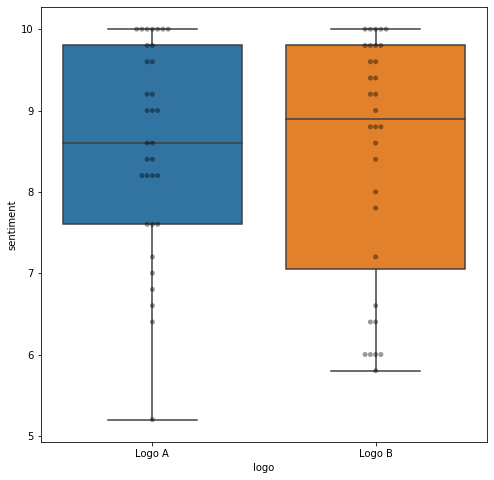

In [17]:
ax = plt.figure(figsize=(8,8)).gca() # define axis
temp = dat[dat.logo != 'Logo C']
sns.boxplot(x = 'logo', y = 'sentiment', data = temp, ax = ax)
sns.swarmplot(x = 'logo', y = 'sentiment', color = 'black', data = temp, ax = ax, alpha = 0.4)

![](Mod5_Lab3_-_Experiments_files/figure-markdown_strict/unnamed-chunk-20-1.png)

Second, I present the results. Generally, I try to state what we
observed first, quantifying the size of the observed results. Second, I
try to state something about whether the effect is significant, using
common language where possible. Third, I try to present some measure of
uncertainty (e.g., our CI), interpreting in plain language as much as
possible. Here is a paragraph possibility:

> The average sentiment for Logo A was slightly higher (*M* = 8.57, *SD*
> = 1.27) than the average sentiment for Logo B (*M* = 8.44, *SD* =
> 1.51). This was a small difference...only 0.13 points on the 1-10
> scale. Given our sample size, this was well within what would be
> expected by random chance (i.e., not statistically significant; *t* =
> 0.38, *p* = 0.70). Thus, they were statistically tied.

> It is possible that a small sentiment difference may still exist
> between the two logos. We are 95% confident that the difference is
> somewhere between 0.80 points higher for Logo A and 0.55 pionts higher
> for Logo B. So, if they do differ, they are likely very close to one
> another; however, we woudl need a larger sampel to say something more
> precise than that.

#### Addendum: Power Considerations

We are done with the analysis. However, it's worth briefly chatting
about power. Did our study have much ability to detect a difference
between Logo A and Logo B in the first place? Was it set up to fail?

Recall that power depends on both sample size and effect size. Large
samples can detect small effects. Smaller samples cannot detect small
effects.

We simply feed information about our study (our sample size and request
for 80% power). We can compute the smallest effect we could reliably detect:

In [18]:
tt_ind_solve_power(effect_size=None, nobs1 = 32, alpha=0.05, power=0.8, ratio=1, alternative='two-sided')

0.7114799640615099

Aha. We could **ONLY** reliably detect effects as small as *d* = .71 ...
a "moderate-large" effect. So, this reinforces our conclusion above...
we would have detected a moderate-large difference between Logo A and B,
but if there was a smaller difference, we were prone to miss it.

Why bring this up? Because I want to remind you that a non-significant
result *does not mean the effect was exactl zero*. It would be a mistake
to say "there was NO difference between Logo A and Logo B." Instead, as
we stated above, we should say "there was not a large difference between
Logo A and Logo B." This reinforces that, but you wouldn't need to
report this.

However, this *would* be worth doing prior to running the study as we
plan our sample size. What if we wanted to be able to detect a smaller
difference, say *d* = .20 with our 80% power? In this case, we use the d value that must be achieved 
*d* value and leave out the number of samples which we want to know:

In [19]:
tt_ind_solve_power(effect_size=0.2, nobs1 = None, alpha=0.05, power=0.8, ratio=1, alternative='two-sided')

393.4056989990322

Here we see that we would need nearly 393 people *per logo* to detect
small differences. If we were planning the study from the start, we
might iteratively explore several possible sample sizes to find the
optimal balance between sample size (i.e., cost of the study) and
ability to detect an effect.

Example 1: Inferential Test for Three Groups
============================================

The previous example considered only two groups: Logo A and Logo B.
However, we had three logos in our study.

When three or more groups are present, we switch from a *t*-test to
*ANOVA* (ANalysis Of VAriance).

The ANOVA is a two stage analysis. In the first stage, we test whether
we can the logo mattered at *all* (i.e., null hypothesis says there were
*no* differences:
*H*<sub>0</sub> : *μ*<sub>*A*</sub> = *μ*<sub>*B*</sub> = *μ*<sub>*C*</sub>).
If that comes up significant, we can systematically compare the logos.

In this example, I assume you are familiar with ANOVA. An overview of
the math behind ANOVA goes beyond the scope of this lab. Essentially,
ANOVA computes the *F* statistic, which yields a *p*-value for the null
hypothesis that all the groups are equal. If we can reject that null
hypothesis, it means the logo is doing something. I illustrate this
next.

The `f_oneway` function from the scipy.stats package computes the F-Statistic and p-value for two or more groups. In this case, the groups are subsets defined by the three logos being tested:

In [20]:
f_statistic, p_value = ss.f_oneway(dat.loc[dat.logo == 'Logo A', 'sentiment'],
                                   dat.loc[dat.logo == 'Logo B', 'sentiment'],
                                   dat.loc[dat.logo == 'Logo C', 'sentiment'])
print('F-Satatistic = ' + str(f_statistic))
print('p_value = ' + str(p_value))

F-Satatistic = 13.611076880502567
p_value = 6.251108050657806e-06


This first step tests the null hypothesis that *all the group means are
equall* ... in other words that the logo doesn't matter **at all**. In
this case, the *p* value is 6.25e-06 (aka 0.00000625). This is highly
statistically significant (*p* &lt; .05). By definition, this means that
we could only get a logo effect this big 0.000625% of the time by random
chance alone. So we are confident the logo is doing something.

Why did we bother with the test described above? Consider what would
happen had we done several *t*-tests. There were three possible
*t*-tests we could have conducted, each of which has the possibility of
giving us a false positive. If we were to run *many* tests, we would
likely stumble across a false-positive eventually. Thus, we appreciate
the ability to conduct a **single** overall test to tell us our logo is
doing something.

The next step is to figure out where the differences are. Recall we made
a table of results earlier with using the Pandas `groupby` and `mean()` methods.

To avoid the issue described above, we use a special test (there are
many; I cover Tukey's HSD here) that takes into account the number of
comparisons we want to make. We wish to make 3 comparisons:

1.  A vs. B
2.  A vs. C
3.  B vs. C

Tukey's test knows how many comparisons we want to make. It inflates our
*p*-values on each test, making it harder to detect a difference for any
one comparison. This *reduces* our likelihood of making a false positive
on any one comparison, counteracting the problem of running multiple
tests. Neat!

It is easy to run. The `pairwise_tukeyhsd` from the statsmodels.stats.multicomp package computes these differences:

In [21]:
Tukey_HSD = pairwise_tukeyhsd(dat.sentiment, dat.logo)
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
Logo A Logo B   -0.132   0.9 -0.9423  0.6783  False
Logo A Logo C  -1.5758 0.001 -2.3739 -0.7776   True
Logo B Logo C  -1.4438 0.001 -2.2482 -0.6393   True
---------------------------------------------------


The output above also gave us difference scores + 95% CIs. Very handy:

1.  Group A vs. B = not significant. Logo B was 0.13 points lower than Logo A. We are 95% confident the
    true difference is between -0.94 and 0.68. This includes zero, so we
    cannot declare a difference between Logo B and Logo A.

2.  Group A vs. C = highly significant. Logo C was 1.58 points lower than Logo A. We are 95% confident the
    true difference is between -2.37 and -0.78.

3.  Group B vs C = highly significant. Logo C was 1.44 points lower than Logo A. We are 95% confident the
    true difference is between -2.25 and -0.64.

As in the *t*-test example above, we see the confidence intervals are
helpful. If we wanted more precise CIs, we need a larger sample.

We can see these confidence intervals for each of the means visually by applying the `plot_simultaneous` method:

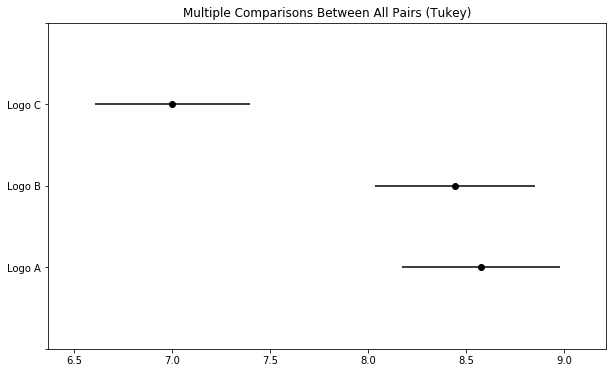

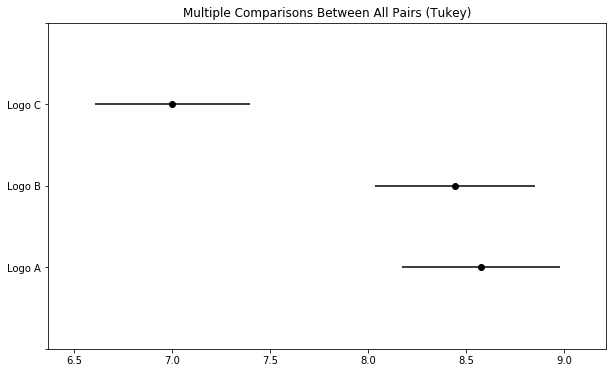

In [22]:
Tukey_HSD.plot_simultaneous()

### Final Report

A report might look as follows:

> The average sentiment on a 1-10 scale is as follows:

In [23]:
logo_grouped = dat[['logo','sentiment']].groupby('logo')

print(' Mean by logo')
print(logo_grouped.mean().round(2))
print('\n Standard deviation by logo')
print(logo_grouped.std().round(2))

 Mean by logo
        sentiment
logo             
Logo A       8.58
Logo B       8.44
Logo C       7.00

 Standard deviation by logo
        sentiment
logo             
Logo A       1.27
Logo B       1.51
Logo C       1.33


> An ANOVA revealed a signifiant effect of logo on sentiment (*F* =
> 13.61, *p* &lt; .001). As shown in the table above, Logos A and B were
> similar in sentiment, while Logo C had reduced sentiment. The pattern
> of results was such that Logos A and B were statistically tied, and
> both performed better than Logo C. Further, the confidence intervals computed with the Tukey HSD test supports this conclusion.

Given the number of results, one could then report the CIs or *p*-values
above in a table or in paragraph form. It is possible to go into the
same level of detail as for the *t*-test, but people usually don't, as
it becomes exponentially more complicated with all the comparisons going
on.